<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

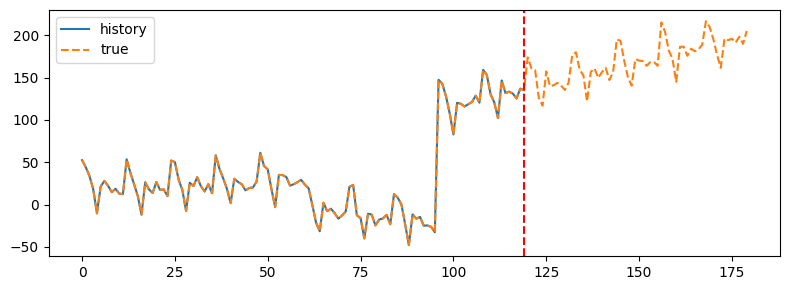

In [4]:
# ==========================================================
# 1. Generate Synthetic Time Series (History + Future Ground Truth)
# ==========================================================
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (5*12)] = 0.2
    slope[(time >= (5*12)) & (time < (8*12))] = -0.4
    slope[time >= (8*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

# 10 years history
time_history = np.arange(10*12, dtype=np.float32)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

# 15 years total (future only for comparison)
time_true = np.arange(15*12, dtype=np.float32)
ts_true = baseline + trend(time=time_true)\
    + seasonality(time=time_true, period=period, amplitude=amplitude)\
    + noise(time=time_true)
ts_true = ts_true.astype(np.float32)

# Plot
plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_true, y=ts_true, label='true', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
# ==========================================================
# 2. Dataset
# ==========================================================
from sklearn import preprocessing
import torch

# Scale and build dataset
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(X=ts_history.reshape(-1, 1)).flatten()

class Seq2SeqDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len, tgt_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).view(-1, 1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.idxs = list(range(len(ts) - (src_len + tgt_len) + 1))

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        src = self.ts[i : i + self.src_len]
        tgt = self.ts[i + self.src_len : i + self.src_len + self.tgt_len]
        return src, tgt

src_len = 24; tgt_len = 12
ds_train = Seq2SeqDataset(ts=ts_scaled, src_len=src_len, tgt_len=tgt_len)
torch.manual_seed(seed=42)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16,
    shuffle=True)
dl_val = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16,
    shuffle=False)

src, tgt = next(iter(dl_val))
print(src.shape, tgt.shape)

torch.Size([16, 24, 1]) torch.Size([16, 12, 1])


In [6]:
# ===========================================================
# 3. Transformer model
# ===========================================================
import numpy as np
import torch

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(size=(1, max_len, d_model))
        pos = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(dim=1)
        div = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            *(-np.log(10000.0) / d_model))
        pe[0, :, 0::2] = torch.sin(pos * div)
        pe[0, :, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerForecast(torch.nn.Module):
    def __init__(self, num_features=1, d_model=128):
        super().__init__()

        self.enc_emb = torch.nn.Linear(in_features=num_features,
            out_features=d_model)
        self.dec_emb = torch.nn.Linear(in_features=num_features,
            out_features=d_model)
        self.positional = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=4,
            batch_first=True, num_encoder_layers=2, num_decoder_layers=2)

        self.output_proj = torch.nn.Linear(in_features=d_model,
            out_features=num_features)

    def forward(self, src, tgt):
        src = self.enc_emb(src)
        src = self.positional(src)

        tgt = self.dec_emb(tgt)
        tgt = self.positional(tgt)
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.size(1))

        out = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        return self.output_proj(out)

torch.manual_seed(seed=42)
model = TransformerForecast()

total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

src, tgt = next(iter(dl_val))
out = model(src=src, tgt=tgt)
print(tgt.shape, out.shape)

Total model parameters: 2505857
torch.Size([16, 12, 1]) torch.Size([16, 12, 1])


Training duration: 135.10s


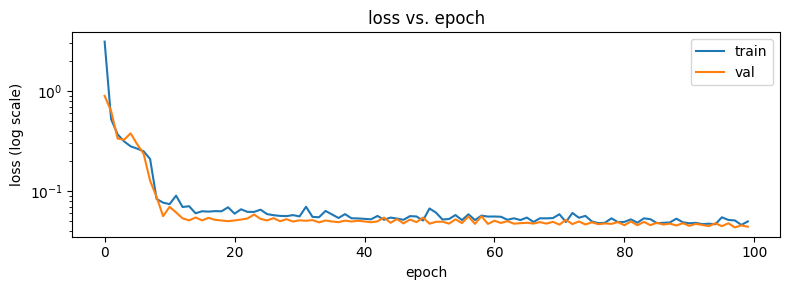

In [7]:
# ==========================================================
# 4. Training & Validation (No Teacher Forcing in Validation)
# ==========================================================
import torch
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl_train, criterion, optimizer, device):
    model.train()
    losses = []
    for batch in dl_train:
        src, tgt = [x.to(device) for x in batch]
        tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)

        out = model(src=src, tgt=tgt_in)

        loss = criterion(input=out, target=tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl_val, criterion, device):
    model.eval()
    losses = []
    for batch in dl_val:
        src, tgt = [x.to(device) for x in batch]
        tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)

        out = model(src=src, tgt=tgt_in)

        loss = criterion(input=out, target=tgt)
        losses.append(loss.item())
    return np.mean(losses)

def training(model, dl_train, dl_val, model_path, max_epochs, device):
    model = model.to(device)
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
        mode='min', factor=0.9, patience=5)

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    for epoch in range(max_epochs):
        train_loss = train_step(model=model, dl_train=dl_train,
            criterion=criterion, optimizer=optimizer, device=device)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl_val=dl_val, criterion=criterion,
            device=device)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(obj=model.state_dict(), f=model_path)

    return history

torch.manual_seed(seed=42)
model = TransformerForecast()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.makedirs('models', exist_ok=True)
model_path = 'models/best_model.pth'

start_time = time.time()
history = training(model=model, dl_train=dl_train, dl_val=dl_val,
    model_path=model_path, max_epochs=100, device=device)
print("Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

plot_history(history=history)

In [31]:
# ===========================================================
# 5. Autoregressive Forecasting (60 months = 5 years)
# ===========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast().to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

src_idx = np.arange(stop=src_len) \
    + np.arange(stop=len(ts_scaled)-src_len+1).reshape(-1, 1)
src = ts_scaled[idx]

# src_preds = []
# for i in range(len(ts_scaled) - src_len + 1):
#     src_preds.append(ts_scaled[i : i + src_len])
# src_pred = np.stack(arrays=src_preds, axis=0)
# src_pred = torch.tensor(data=src_pred, dtype=torch.float32)
# src_pred.shape

# @torch.no_grad()
# def predict(model, ts):
#     model.eval()
#     preds = []
#     for batch in dl_val:
#         src, tgt = [x.to(device) for x in batch]
#         tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)

#         out = model(src=src, tgt=tgt_in)
#         pred = out[:, -1]
#         preds.append(out[:, -1].squeeze())
#     preds = torch.concatenate(tensors=preds)
#     return preds

# ts_pred = predict(model=model, dl_val=dl_val)
# ts_pred = scaler.inverse_transform(X=ts_pred.reshape(-1, 1)).flatten()
# time_pred = time_history[-len(ts_pred):]


# steps = 60
# time_future = np.arange(start=len(ts_history), stop=len(ts_history)+steps, dtype=np.float32)
# ts_future = forecast(model=model, ts=ts_history, src_len=src_len, steps=steps)

# Plot
# plt.figure(figsize=(8, 3))
# sns.lineplot(x=time_history, y=ts_history, label='history')
# sns.lineplot(x=time_true, y=ts_true, label='true', linestyle='--')
# sns.lineplot(x=time_pred, y=ts_pred, label='forecast', linestyle='--')
# plt.axvline(x=time_history[-1], color='red', linestyle='--')
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

array([[-0.03124416, -0.11171162, -0.21320266, ..., -0.3710826 ,
        -0.36399594, -0.4411206 ],
       [-0.11171162, -0.21320266, -0.36212176, ..., -0.36399594,
        -0.4411206 , -0.03515929],
       [-0.21320266, -0.36212176, -0.6381321 , ..., -0.4411206 ,
        -0.03515929, -0.05333531],
       ...,
       [-0.79171556, -0.85431504,  0.8859966 , ...,  0.75060844,
         0.7291845 ,  0.6725333 ],
       [-0.85431504,  0.8859966 ,  0.8422158 , ...,  0.7291845 ,
         0.6725333 ,  0.7847774 ],
       [ 0.8859966 ,  0.8422158 ,  0.6981491 , ...,  0.6725333 ,
         0.7847774 ,  0.7685491 ]], dtype=float32)

120

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=1, out_dim=1,
    d_model=128, nhead=8, num_layers=2
).to(device)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt_y.shape[1])

        x = np.arange(src.shape[1] + tgt_y.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt_y[idx].cpu().detach(), "go-", label="tgt_y")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()